In [18]:
# Modelagem de Dados - Componentes de Computador

## Objetivo
## Desenvolver modelos preditivos para diferentes problemas relacionados aos componentes de computador:

### Problemas Alvo Definidos:
## 1. **Predição de Consumo Energético de CPUs** (Regressão)
## 2. **Classificação de Faixas de Preço de GPUs** (Classificação)
## 3. **Predição de Performance de RAM** (Regressão)
## 4. **Classificação de Categoria de PSU por Eficiência** (Classificação)

## Metodologia
## - **Preparação dos dados**: Limpeza, transformação e feature engineering
## - **Divisão treino/teste**: 80/20 com validação cruzada
## - **Modelos testados**: Regressão Linear, Random Forest, XGBoost, SVM
## - **Avaliação**: Métricas apropriadas para cada tipo de problema
## - **Comparação**: Análise comparativa dos modelos


In [19]:
# Importação das bibliotecas necessárias
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                           accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
try:
    import xgboost as xgb
    xgb_available = True
except ImportError:
    print("XGBoost não disponível. Instalando...")
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost"])
    import xgboost as xgb
    xgb_available = True

import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Bibliotecas de Machine Learning carregadas com sucesso!")


Bibliotecas de Machine Learning carregadas com sucesso!


In [20]:
# Carregamento dos dados
def carregar_dados(arquivo):
    """Carrega dados de um arquivo JSON"""
    with open(f'data/{arquivo}', 'r', encoding='utf-8') as f:
        dados = json.load(f)
    return pd.DataFrame(dados)

# Carregamento de todos os datasets
datasets = {
    'CPUs': carregar_dados('cpus_clean.json'),
    'GPUs': carregar_dados('gpus_clean.json'),
    'RAM': carregar_dados('ram_clean.json'),
    'Motherboards': carregar_dados('motherboard_clean.json'),
    'PSUs': carregar_dados('psus_clean.json'),
    'SSDs': carregar_dados('ssds_clean.json'),
    'HDDs': carregar_dados('hdds_clean.json')
}

print("=== DATASETS PARA MODELAGEM ===")
for nome, df in datasets.items():
    print(f"{nome}: {len(df)} registros")
    
print("\nDados carregados para modelagem!")


=== DATASETS PARA MODELAGEM ===
CPUs: 324 registros
GPUs: 1325 registros
RAM: 1648 registros
Motherboards: 1545 registros
PSUs: 916 registros
SSDs: 456 registros
HDDs: 247 registros

Dados carregados para modelagem!


In [21]:
## 1. Problema 1: Predição de Consumo Energético de CPUs (Regressão)

### Objetivo
### Desenvolver um modelo para predizer o consumo energético (TDP) de processadores com base em suas características técnicas.

### Justificativa
### O consumo energético é um fator crítico na escolha de processadores, especialmente para:
### - Sistemas com restrições de energia
### - Laptops e dispositivos móveis
### - Datacenters preocupados com eficiência energética
### - Cálculo de custos operacionais


In [22]:
# PROBLEMA 1: Predição de Consumo Energético de CPUs
print("="*80)
print("PROBLEMA 1: PREDIÇÃO DE CONSUMO ENERGÉTICO DE CPUs")
print("="*80)

# Preparação dos dados de CPUs
cpu_df = datasets['CPUs'].copy()
print(f"Dataset original: {len(cpu_df)} registros")

# Limpeza e preparação dos dados
def preparar_dados_cpu(df):
    """Prepara dados de CPU para modelagem"""
    # Criar cópia
    df_clean = df.copy()
    
    # Extrair valores numéricos de consumo
    df_clean['consumption_numeric'] = pd.to_numeric(df_clean['consumption'].str.extract(r'(\d+)')[0], errors='coerce')
    
    # Extrair valores numéricos de clock base
    df_clean['base_clock_numeric'] = pd.to_numeric(df_clean['base_clock_spd'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
    
    # Extrair valores numéricos de boost clock - tratar valores vazios
    df_clean['boost_clock_numeric'] = pd.to_numeric(df_clean['boost_clock_spd'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
    
    # Preencher valores ausentes de boost_clock com base_clock (assumindo que não há boost)
    df_clean['boost_clock_numeric'] = df_clean['boost_clock_numeric'].fillna(df_clean['base_clock_numeric'])
    
    # Remover registros com dados ausentes nas variáveis críticas
    df_clean = df_clean.dropna(subset=['consumption_numeric', 'n_cores', 'base_clock_numeric', 'boost_clock_numeric'])
    
    # Criar variáveis dummy para fabricante
    df_clean = pd.get_dummies(df_clean, columns=['manufacturer'], prefix='fab')
    
    # Criar variável dummy para overclock
    df_clean['overclock_num'] = df_clean['overclock'].astype(int)
    
    return df_clean

# Preparar dados
cpu_clean = preparar_dados_cpu(cpu_df)
print(f"Dataset limpo: {len(cpu_clean)} registros")
print(f"Variáveis disponíveis: {cpu_clean.columns.tolist()}")

# Definir features e target
feature_columns = ['n_cores', 'base_clock_numeric', 'boost_clock_numeric', 'overclock_num']
# Adicionar colunas de fabricante
feature_columns.extend([col for col in cpu_clean.columns if col.startswith('fab_')])

X = cpu_clean[feature_columns]
y = cpu_clean['consumption_numeric']

print(f"\nFeatures selecionadas: {feature_columns}")
print(f"Target: consumption_numeric")
print(f"Dados para modelagem: {len(X)} registros, {len(feature_columns)} features")

# Verificar correlações
print("\n=== CORRELAÇÕES COM O TARGET ===")
correlation_matrix = cpu_clean[feature_columns + ['consumption_numeric']].corr()
target_correlations = correlation_matrix['consumption_numeric']
# Remover a correlação consigo mesmo
target_correlations = target_correlations[target_correlations.index != 'consumption_numeric']
# Ordenar por valores absolutos
target_correlations = target_correlations.reindex(target_correlations.abs().sort_values(ascending=False).index)
print(target_correlations)


PROBLEMA 1: PREDIÇÃO DE CONSUMO ENERGÉTICO DE CPUs
Dataset original: 324 registros
Dataset limpo: 317 registros
Variáveis disponíveis: ['model', 'socket', 'n_cores', 'base_clock_spd', 'boost_clock_spd', 'consumption', 'integrated_gpu', 'overclock', 'consumption_numeric', 'base_clock_numeric', 'boost_clock_numeric', 'fab_AMD', 'fab_Intel', 'overclock_num']

Features selecionadas: ['n_cores', 'base_clock_numeric', 'boost_clock_numeric', 'overclock_num', 'fab_AMD', 'fab_Intel']
Target: consumption_numeric
Dados para modelagem: 317 registros, 6 features

=== CORRELAÇÕES COM O TARGET ===
n_cores                0.725195
overclock_num          0.308280
boost_clock_numeric    0.299967
fab_AMD                0.166879
fab_Intel             -0.166879
base_clock_numeric     0.050087
Name: consumption_numeric, dtype: float64


In [23]:
# Verificar e tratar valores NaN antes da divisão
print(f"Valores NaN em X: {X.isnull().sum().sum()}")
print(f"Valores NaN em y: {y.isnull().sum()}")

# Remover qualquer linha com NaN restante
mask_valid = ~(X.isnull().any(axis=1) | y.isnull())
X_clean = X[mask_valid]
y_clean = y[mask_valid]

print(f"Dados finais após limpeza: {len(X_clean)} registros")

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

# Verificar novamente se há NaN
print(f"NaN em X_train: {np.isnan(X_train).sum()}")
print(f"NaN em y_train: {np.isnan(y_train).sum()}")

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dicionário para armazenar resultados
resultados_cpu = {}

print("\n" + "="*60)
print("TREINAMENTO DOS MODELOS - REGRESSÃO")
print("="*60)

# 1. Regressão Linear
print("\n1. REGRESSÃO LINEAR")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Métricas
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

resultados_cpu['Linear Regression'] = {
    'MSE': mse_lr,
    'RMSE': rmse_lr,
    'MAE': mae_lr,
    'R²': r2_lr
}

print(f"MSE: {mse_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mae_lr:.2f}")
print(f"R²: {r2_lr:.3f}")

# 2. Random Forest
print("\n2. RANDOM FOREST")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Random Forest não precisa de normalização
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

resultados_cpu['Random Forest'] = {
    'MSE': mse_rf,
    'RMSE': rmse_rf,
    'MAE': mae_rf,
    'R²': r2_rf
}

print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.3f}")

# Feature importance do Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance.head(10))

# 3. XGBoost
if xgb_available:
    print("\n3. XGBOOST")
    xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred_xgb = xgb_reg.predict(X_test)
    
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    resultados_cpu['XGBoost'] = {
        'MSE': mse_xgb,
        'RMSE': rmse_xgb,
        'MAE': mae_xgb,
        'R²': r2_xgb
    }
    
    print(f"MSE: {mse_xgb:.2f}")
    print(f"RMSE: {rmse_xgb:.2f}")
    print(f"MAE: {mae_xgb:.2f}")
    print(f"R²: {r2_xgb:.3f}")

# 4. Support Vector Regression
print("\n4. SUPPORT VECTOR REGRESSION")
svr = SVR(kernel='rbf', C=100, gamma='scale')
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

resultados_cpu['SVR'] = {
    'MSE': mse_svr,
    'RMSE': rmse_svr,
    'MAE': mae_svr,
    'R²': r2_svr
}

print(f"MSE: {mse_svr:.2f}")
print(f"RMSE: {rmse_svr:.2f}")
print(f"MAE: {mae_svr:.2f}")
print(f"R²: {r2_svr:.3f}")


Valores NaN em X: 0
Valores NaN em y: 0
Dados finais após limpeza: 317 registros
Dados de treino: (253, 6)
Dados de teste: (64, 6)
NaN em X_train: n_cores                0
base_clock_numeric     0
boost_clock_numeric    0
overclock_num          0
fab_AMD                0
fab_Intel              0
dtype: int64
NaN em y_train: 0

TREINAMENTO DOS MODELOS - REGRESSÃO

1. REGRESSÃO LINEAR
MSE: 812.63
RMSE: 28.51
MAE: 21.97
R²: 0.636

2. RANDOM FOREST
MSE: 473.43
RMSE: 21.76
MAE: 13.85
R²: 0.788

Feature Importance (Random Forest):
               feature  importance
0              n_cores    0.642131
1   base_clock_numeric    0.124071
3        overclock_num    0.101679
2  boost_clock_numeric    0.097927
5            fab_Intel    0.018159
4              fab_AMD    0.016033

3. XGBOOST


MSE: 620.58
RMSE: 24.91
MAE: 15.99
R²: 0.722

4. SUPPORT VECTOR REGRESSION
MSE: 379.68
RMSE: 19.49
MAE: 14.17
R²: 0.830



COMPARAÇÃO DOS MODELOS - CPUs
                          MSE       RMSE        MAE        R²
Linear Regression  812.626409  28.506603  21.966624  0.636115
Random Forest      473.430078  21.758448  13.850227  0.788003
XGBoost            620.583740  24.911518  15.985167  0.722109
SVR                379.681191  19.485410  14.169006  0.829983

Melhor modelo: SVR (R² = 0.830)


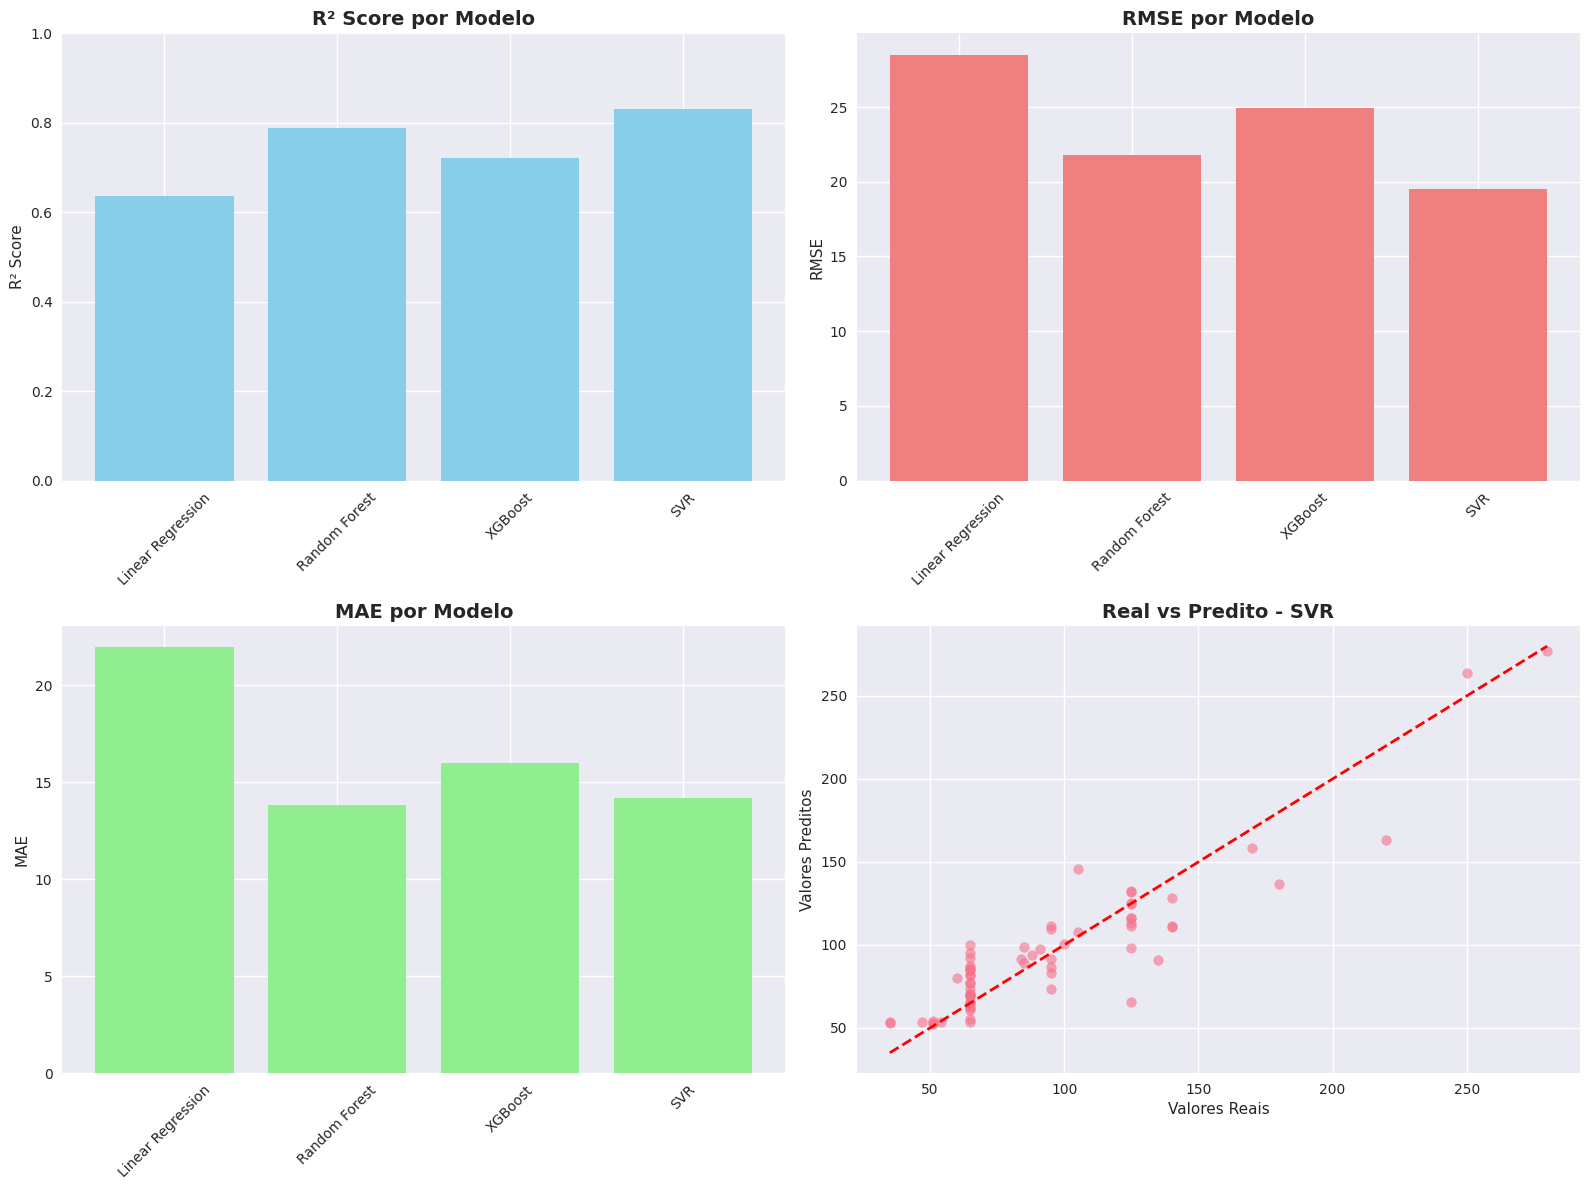


=== VALIDAÇÃO CRUZADA - SVR ===
CV R² Scores: [0.66233813 0.788363   0.81949034 0.73999706 0.68654945]
Média: 0.739 (+/- 0.118)


In [24]:
# Visualização dos resultados
print("\n" + "="*60)
print("COMPARAÇÃO DOS MODELOS - CPUs")
print("="*60)

# Criar DataFrame com resultados
df_resultados_cpu = pd.DataFrame(resultados_cpu).T
print(df_resultados_cpu)

# Gráficos de comparação
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score
modelos = list(resultados_cpu.keys())
r2_scores = [resultados_cpu[modelo]['R²'] for modelo in modelos]
axes[0,0].bar(modelos, r2_scores, color='skyblue')
axes[0,0].set_title('R² Score por Modelo', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# 2. RMSE
rmse_scores = [resultados_cpu[modelo]['RMSE'] for modelo in modelos]
axes[0,1].bar(modelos, rmse_scores, color='lightcoral')
axes[0,1].set_title('RMSE por Modelo', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('RMSE')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. MAE
mae_scores = [resultados_cpu[modelo]['MAE'] for modelo in modelos]
axes[1,0].bar(modelos, mae_scores, color='lightgreen')
axes[1,0].set_title('MAE por Modelo', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('MAE')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Comparação Real vs Predito (melhor modelo)
melhor_modelo = max(resultados_cpu.keys(), key=lambda x: resultados_cpu[x]['R²'])
print(f"\nMelhor modelo: {melhor_modelo} (R² = {resultados_cpu[melhor_modelo]['R²']:.3f})")

# Usar predições do melhor modelo
if melhor_modelo == 'Random Forest':
    y_pred_best = y_pred_rf
elif melhor_modelo == 'Linear Regression':
    y_pred_best = y_pred_lr
elif melhor_modelo == 'XGBoost' and xgb_available:
    y_pred_best = y_pred_xgb
else:
    y_pred_best = y_pred_svr

axes[1,1].scatter(y_test, y_pred_best, alpha=0.6)
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,1].set_title(f'Real vs Predito - {melhor_modelo}', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Valores Reais')
axes[1,1].set_ylabel('Valores Preditos')

plt.tight_layout()
plt.show()

# Validação cruzada do melhor modelo
print(f"\n=== VALIDAÇÃO CRUZADA - {melhor_modelo} ===")
if melhor_modelo == 'Random Forest':
    cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
elif melhor_modelo == 'Linear Regression':
    cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
elif melhor_modelo == 'XGBoost' and xgb_available:
    cv_scores = cross_val_score(xgb_reg, X, y, cv=5, scoring='r2')
else:
    cv_scores = cross_val_score(svr, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"CV R² Scores: {cv_scores}")
print(f"Média: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


In [25]:
# PROBLEMA 2: Classificação de Faixas de VRAM de GPUs
print("="*80)
print("PROBLEMA 2: CLASSIFICAÇÃO DE FAIXAS DE VRAM DE GPUs")
print("="*80)

# Preparação dos dados de GPUs
gpu_df = datasets['GPUs'].copy()
print(f"Dataset original: {len(gpu_df)} registros")

# Função para preparar dados de GPU
def preparar_dados_gpu(df):
    """Prepara dados de GPU para classificação"""
    df_clean = df.copy()
    
    # Extrair valores numéricos com regex correta
    df_clean['vram_numeric'] = pd.to_numeric(df_clean['vram'].str.extract(r'(\d+)')[0], errors='coerce')
    df_clean['consumption_numeric'] = pd.to_numeric(df_clean['consumption'].str.extract(r'(\d+)')[0], errors='coerce')
    df_clean['vram_spd_numeric'] = pd.to_numeric(df_clean['vram_spd'].str.extract(r'(\d+)')[0], errors='coerce')
    
    # Remover registros com dados ausentes
    df_clean = df_clean.dropna(subset=['vram_numeric', 'consumption_numeric', 'vram_spd_numeric'])
    
    # Criar categorias de VRAM
    def categorizar_vram(vram):
        if vram <= 2:
            return 'Baixa (≤2GB)'
        elif vram <= 6:
            return 'Média (3-6GB)'
        elif vram <= 12:
            return 'Alta (7-12GB)'
        else:
            return 'Muito Alta (>12GB)'
    
    df_clean['vram_category'] = df_clean['vram_numeric'].apply(categorizar_vram)
    
    # Criar variáveis dummy para fabricante
    df_clean = pd.get_dummies(df_clean, columns=['manufacturer'], prefix='fab')
    
    return df_clean

# Preparar dados
gpu_clean = preparar_dados_gpu(gpu_df)
print(f"Dataset limpo: {len(gpu_clean)} registros")

# Análise das categorias
print("\n=== DISTRIBUIÇÃO DAS CATEGORIAS DE VRAM ===")
category_counts = gpu_clean['vram_category'].value_counts()
print(category_counts)
print(f"Percentuais:")
for cat, count in category_counts.items():
    print(f"{cat}: {(count/len(gpu_clean)*100):.1f}%")

# Definir features e target
feature_columns_gpu = ['consumption_numeric', 'vram_spd_numeric']
# Adicionar colunas de fabricante
feature_columns_gpu.extend([col for col in gpu_clean.columns if col.startswith('fab_')])

X_gpu = gpu_clean[feature_columns_gpu]
y_gpu = gpu_clean['vram_category']

print(f"\nFeatures: {len(feature_columns_gpu)} variáveis")
print(f"Target: {len(y_gpu.unique())} categorias")

# Verificar valores NaN
print(f"Valores NaN em X_gpu: {X_gpu.isnull().sum().sum()}")
print(f"Valores NaN em y_gpu: {y_gpu.isnull().sum()}")

# Divisão treino/teste
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(
    X_gpu, y_gpu, test_size=0.2, random_state=42, stratify=y_gpu
)

print(f"Dados de treino: {len(X_train_gpu)} registros")
print(f"Dados de teste: {len(X_test_gpu)} registros")

# Normalização
scaler_gpu = StandardScaler()
X_train_gpu_scaled = scaler_gpu.fit_transform(X_train_gpu)
X_test_gpu_scaled = scaler_gpu.transform(X_test_gpu)

# Dicionário para resultados
resultados_gpu = {}

print("\n" + "="*60)
print("TREINAMENTO DOS MODELOS - CLASSIFICAÇÃO")
print("="*60)

# 1. Logistic Regression
print("\n1. REGRESSÃO LOGÍSTICA")
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_gpu_scaled, y_train_gpu)
y_pred_lr_clf = lr_clf.predict(X_test_gpu_scaled)

accuracy_lr = accuracy_score(y_test_gpu, y_pred_lr_clf)
precision_lr = precision_score(y_test_gpu, y_pred_lr_clf, average='weighted')
recall_lr = recall_score(y_test_gpu, y_pred_lr_clf, average='weighted')
f1_lr = f1_score(y_test_gpu, y_pred_lr_clf, average='weighted')

resultados_gpu['Logistic Regression'] = {
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr
}

print(f"Accuracy: {accuracy_lr:.3f}")
print(f"Precision: {precision_lr:.3f}")
print(f"Recall: {recall_lr:.3f}")
print(f"F1-Score: {f1_lr:.3f}")

# 2. Random Forest Classifier
print("\n2. RANDOM FOREST")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_gpu, y_train_gpu)
y_pred_rf_clf = rf_clf.predict(X_test_gpu)

accuracy_rf = accuracy_score(y_test_gpu, y_pred_rf_clf)
precision_rf = precision_score(y_test_gpu, y_pred_rf_clf, average='weighted')
recall_rf = recall_score(y_test_gpu, y_pred_rf_clf, average='weighted')
f1_rf = f1_score(y_test_gpu, y_pred_rf_clf, average='weighted')

resultados_gpu['Random Forest'] = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf
}

print(f"Accuracy: {accuracy_rf:.3f}")
print(f"Precision: {precision_rf:.3f}")
print(f"Recall: {recall_rf:.3f}")
print(f"F1-Score: {f1_rf:.3f}")

# 3. SVM Classifier
print("\n3. SUPPORT VECTOR MACHINE")
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train_gpu_scaled, y_train_gpu)
y_pred_svm = svm_clf.predict(X_test_gpu_scaled)

accuracy_svm = accuracy_score(y_test_gpu, y_pred_svm)
precision_svm = precision_score(y_test_gpu, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test_gpu, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_gpu, y_pred_svm, average='weighted')

resultados_gpu['SVM'] = {
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm
}

print(f"Accuracy: {accuracy_svm:.3f}")
print(f"Precision: {precision_svm:.3f}")
print(f"Recall: {recall_svm:.3f}")
print(f"F1-Score: {f1_svm:.3f}")

print(f"\nFeatures: {len(feature_columns_gpu)} variáveis")
print(f"Target: {len(y_gpu.unique())} categorias")

# Divisão treino/teste
X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(
    X_gpu, y_gpu, test_size=0.2, random_state=42, stratify=y_gpu
)

print(f"Dados de treino: {len(X_train_gpu)} registros")
print(f"Dados de teste: {len(X_test_gpu)} registros")

# Normalização
scaler_gpu = StandardScaler()
X_train_gpu_scaled = scaler_gpu.fit_transform(X_train_gpu)
X_test_gpu_scaled = scaler_gpu.transform(X_test_gpu)

# Dicionário para resultados
resultados_gpu = {}

print("\n" + "="*60)
print("TREINAMENTO DOS MODELOS - CLASSIFICAÇÃO")
print("="*60)

# 1. Logistic Regression
print("\n1. REGRESSÃO LOGÍSTICA")
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_gpu_scaled, y_train_gpu)
y_pred_lr_clf = lr_clf.predict(X_test_gpu_scaled)

accuracy_lr = accuracy_score(y_test_gpu, y_pred_lr_clf)
precision_lr = precision_score(y_test_gpu, y_pred_lr_clf, average='weighted')
recall_lr = recall_score(y_test_gpu, y_pred_lr_clf, average='weighted')
f1_lr = f1_score(y_test_gpu, y_pred_lr_clf, average='weighted')

resultados_gpu['Logistic Regression'] = {
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr
}

print(f"Accuracy: {accuracy_lr:.3f}")
print(f"Precision: {precision_lr:.3f}")
print(f"Recall: {recall_lr:.3f}")
print(f"F1-Score: {f1_lr:.3f}")

# 2. Random Forest Classifier
print("\n2. RANDOM FOREST")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_gpu, y_train_gpu)
y_pred_rf_clf = rf_clf.predict(X_test_gpu)

accuracy_rf = accuracy_score(y_test_gpu, y_pred_rf_clf)
precision_rf = precision_score(y_test_gpu, y_pred_rf_clf, average='weighted')
recall_rf = recall_score(y_test_gpu, y_pred_rf_clf, average='weighted')
f1_rf = f1_score(y_test_gpu, y_pred_rf_clf, average='weighted')

resultados_gpu['Random Forest'] = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf
}

print(f"Accuracy: {accuracy_rf:.3f}")
print(f"Precision: {precision_rf:.3f}")
print(f"Recall: {recall_rf:.3f}")
print(f"F1-Score: {f1_rf:.3f}")

# 3. SVM Classifier
print("\n3. SUPPORT VECTOR MACHINE")
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train_gpu_scaled, y_train_gpu)
y_pred_svm = svm_clf.predict(X_test_gpu_scaled)

accuracy_svm = accuracy_score(y_test_gpu, y_pred_svm)
precision_svm = precision_score(y_test_gpu, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test_gpu, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test_gpu, y_pred_svm, average='weighted')

resultados_gpu['SVM'] = {
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm
}

print(f"Accuracy: {accuracy_svm:.3f}")
print(f"Precision: {precision_svm:.3f}")
print(f"Recall: {recall_svm:.3f}")
print(f"F1-Score: {f1_svm:.3f}")


PROBLEMA 2: CLASSIFICAÇÃO DE FAIXAS DE VRAM DE GPUs
Dataset original: 1325 registros
Dataset limpo: 1297 registros

=== DISTRIBUIÇÃO DAS CATEGORIAS DE VRAM ===
vram_category
Alta (7-12GB)         743
Média (3-6GB)         330
Muito Alta (>12GB)    113
Baixa (≤2GB)          111
Name: count, dtype: int64
Percentuais:
Alta (7-12GB): 57.3%
Média (3-6GB): 25.4%
Muito Alta (>12GB): 8.7%
Baixa (≤2GB): 8.6%

Features: 22 variáveis
Target: 4 categorias
Valores NaN em X_gpu: 0
Valores NaN em y_gpu: 0
Dados de treino: 1037 registros
Dados de teste: 260 registros

TREINAMENTO DOS MODELOS - CLASSIFICAÇÃO

1. REGRESSÃO LOGÍSTICA
Accuracy: 0.731
Precision: 0.725
Recall: 0.731
F1-Score: 0.693

2. RANDOM FOREST
Accuracy: 0.850
Precision: 0.859
Recall: 0.850
F1-Score: 0.852

3. SUPPORT VECTOR MACHINE
Accuracy: 0.712
Precision: 0.668
Recall: 0.712
F1-Score: 0.654

Features: 22 variáveis
Target: 4 categorias
Dados de treino: 1037 registros
Dados de teste: 260 registros

TREINAMENTO DOS MODELOS - CLASSIFIC


COMPARAÇÃO DOS MODELOS - CLASSIFICAÇÃO GPU
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.730769   0.724804  0.730769  0.693382
Random Forest        0.850000   0.859419  0.850000  0.851786
SVM                  0.711538   0.667946  0.711538  0.654249

Melhor modelo de classificação: Random Forest


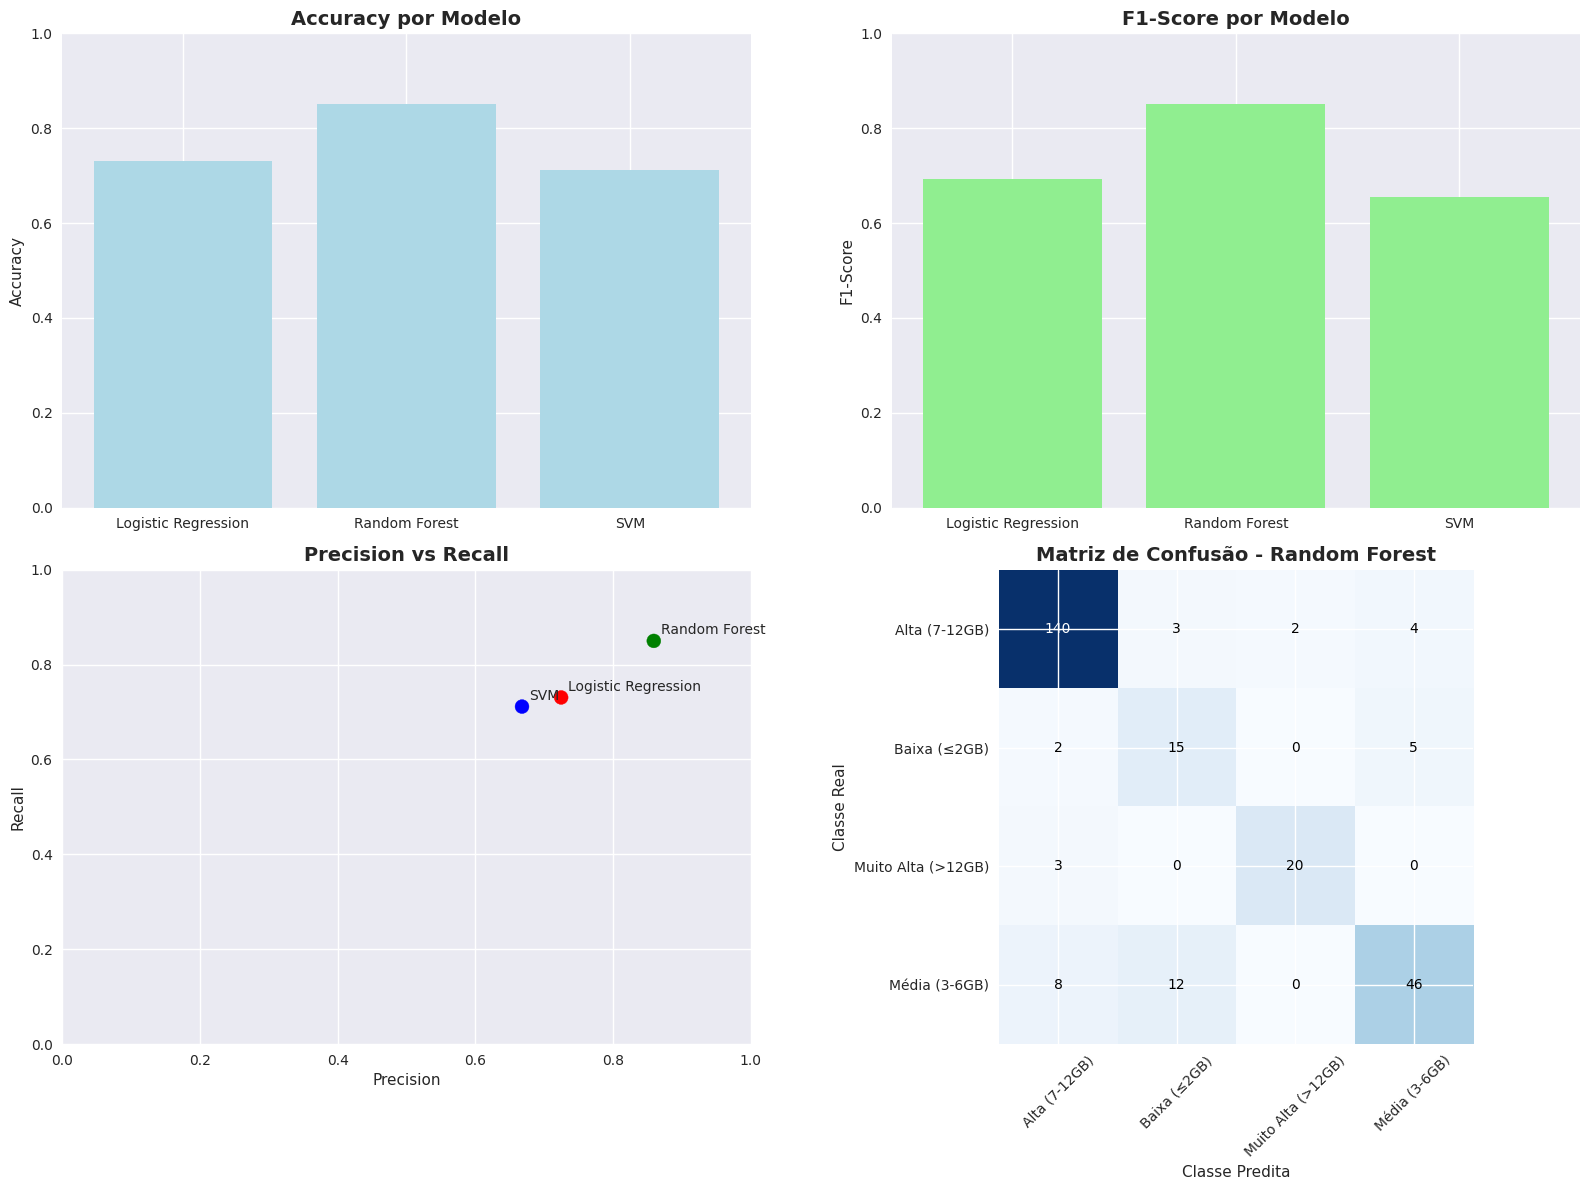


=== RELATÓRIO DETALHADO - Random Forest ===
                    precision    recall  f1-score   support

     Alta (7-12GB)       0.92      0.94      0.93       149
      Baixa (≤2GB)       0.50      0.68      0.58        22
Muito Alta (>12GB)       0.91      0.87      0.89        23
     Média (3-6GB)       0.84      0.70      0.76        66

          accuracy                           0.85       260
         macro avg       0.79      0.80      0.79       260
      weighted avg       0.86      0.85      0.85       260



In [26]:
# Visualização dos resultados de classificação
print("\n" + "="*60)
print("COMPARAÇÃO DOS MODELOS - CLASSIFICAÇÃO GPU")
print("="*60)

# DataFrame com resultados
df_resultados_gpu = pd.DataFrame(resultados_gpu).T
print(df_resultados_gpu)

# Gráficos de comparação
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy
modelos_gpu = list(resultados_gpu.keys())
accuracy_scores = [resultados_gpu[modelo]['Accuracy'] for modelo in modelos_gpu]
axes[0,0].bar(modelos_gpu, accuracy_scores, color='lightblue')
axes[0,0].set_title('Accuracy por Modelo', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)

# 2. F1-Score
f1_scores = [resultados_gpu[modelo]['F1-Score'] for modelo in modelos_gpu]
axes[0,1].bar(modelos_gpu, f1_scores, color='lightgreen')
axes[0,1].set_title('F1-Score por Modelo', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_ylim(0, 1)

# 3. Precision vs Recall
precision_scores = [resultados_gpu[modelo]['Precision'] for modelo in modelos_gpu]
recall_scores = [resultados_gpu[modelo]['Recall'] for modelo in modelos_gpu]
axes[1,0].scatter(precision_scores, recall_scores, s=100, c=['red', 'green', 'blue'])
for i, modelo in enumerate(modelos_gpu):
    axes[1,0].annotate(modelo, (precision_scores[i], recall_scores[i]), 
                      xytext=(5, 5), textcoords='offset points')
axes[1,0].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Precision')
axes[1,0].set_ylabel('Recall')
axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(0, 1)

# 4. Matriz de confusão do melhor modelo
melhor_modelo_gpu = max(resultados_gpu.keys(), key=lambda x: resultados_gpu[x]['Accuracy'])
print(f"\nMelhor modelo de classificação: {melhor_modelo_gpu}")

if melhor_modelo_gpu == 'Random Forest':
    y_pred_best_gpu = y_pred_rf_clf
elif melhor_modelo_gpu == 'Logistic Regression':
    y_pred_best_gpu = y_pred_lr_clf
else:
    y_pred_best_gpu = y_pred_svm

# Matriz de confusão
cm = confusion_matrix(y_test_gpu, y_pred_best_gpu)
labels = sorted(y_gpu.unique())

# Plotar matriz de confusão
im = axes[1,1].imshow(cm, interpolation='nearest', cmap='Blues')
axes[1,1].set_title(f'Matriz de Confusão - {melhor_modelo_gpu}', fontsize=14, fontweight='bold')
tick_marks = np.arange(len(labels))
axes[1,1].set_xticks(tick_marks)
axes[1,1].set_yticks(tick_marks)
axes[1,1].set_xticklabels(labels, rotation=45)
axes[1,1].set_yticklabels(labels)

# Adicionar valores na matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[1,1].text(j, i, format(cm[i, j], 'd'),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")

axes[1,1].set_ylabel('Classe Real')
axes[1,1].set_xlabel('Classe Predita')

plt.tight_layout()
plt.show()

# Relatório de classificação detalhado
print(f"\n=== RELATÓRIO DETALHADO - {melhor_modelo_gpu} ===")
print(classification_report(y_test_gpu, y_pred_best_gpu))



COMPARAÇÃO DOS MODELOS - CLASSIFICAÇÃO GPU
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.730769   0.724804  0.730769  0.693382
Random Forest        0.850000   0.859419  0.850000  0.851786
SVM                  0.711538   0.667946  0.711538  0.654249

Melhor modelo de classificação: Random Forest


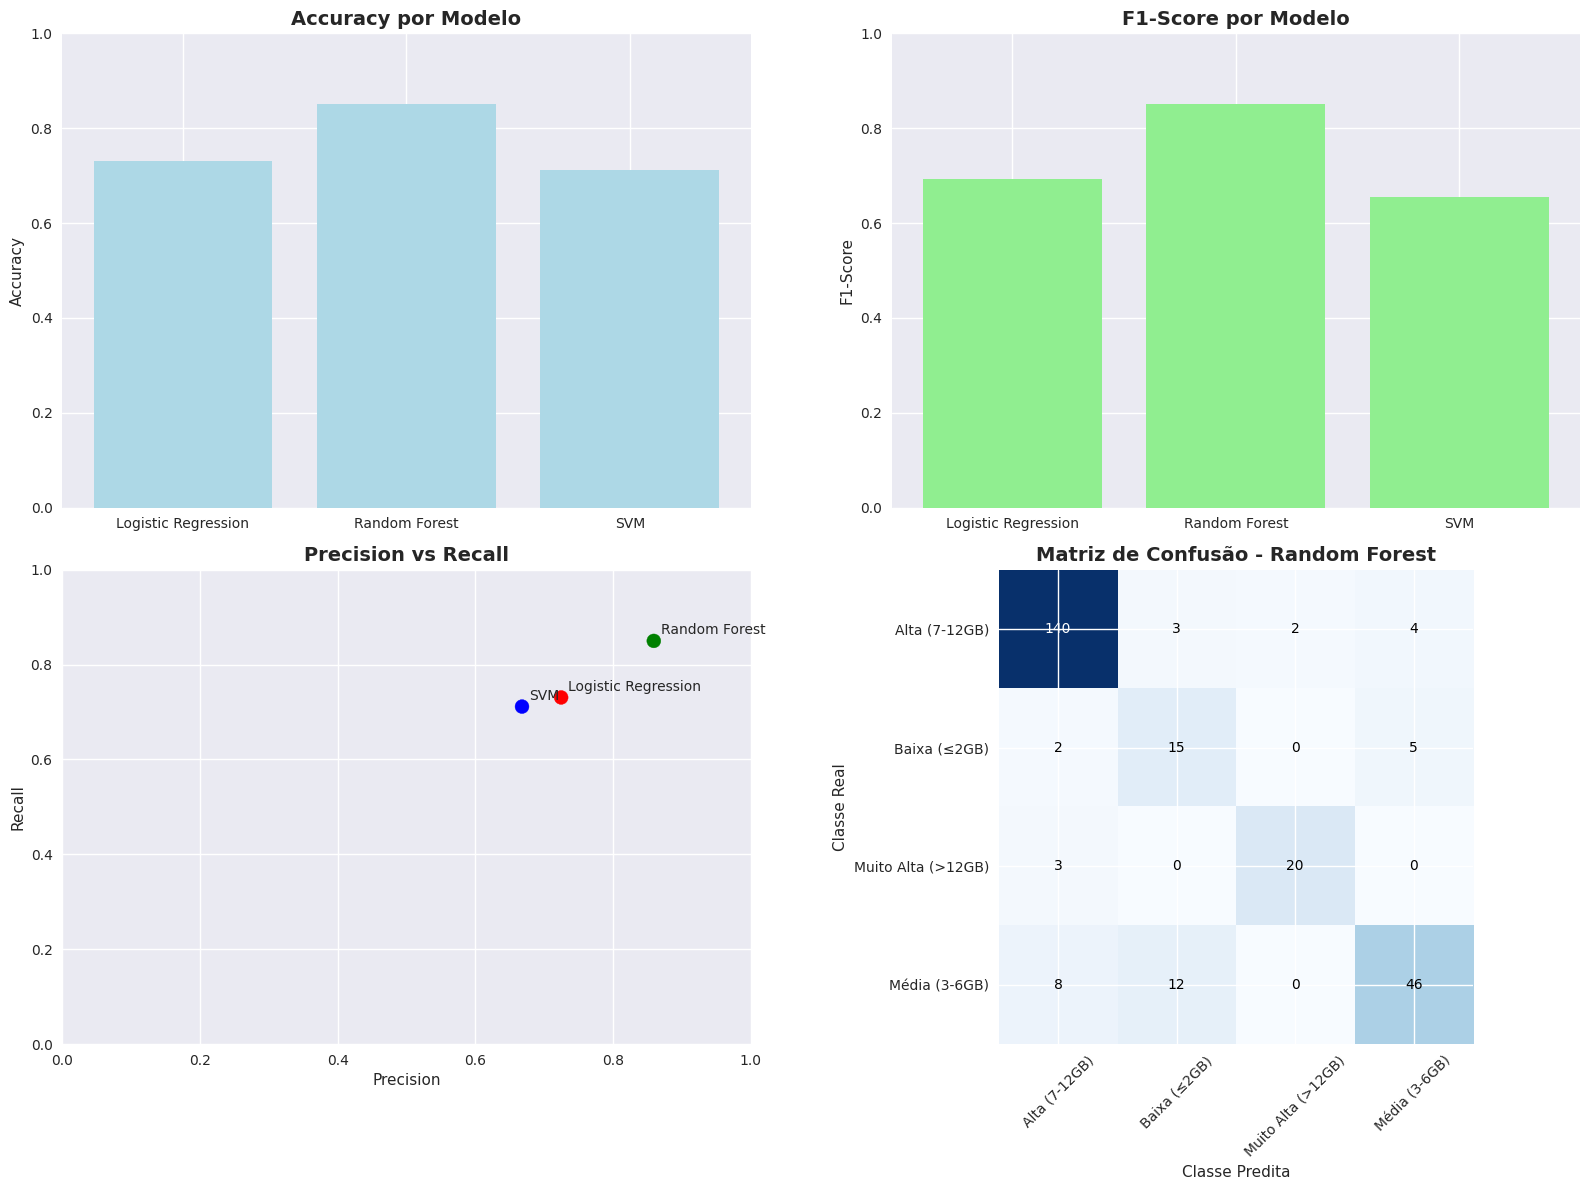


=== RELATÓRIO DETALHADO - Random Forest ===
                    precision    recall  f1-score   support

     Alta (7-12GB)       0.92      0.94      0.93       149
      Baixa (≤2GB)       0.50      0.68      0.58        22
Muito Alta (>12GB)       0.91      0.87      0.89        23
     Média (3-6GB)       0.84      0.70      0.76        66

          accuracy                           0.85       260
         macro avg       0.79      0.80      0.79       260
      weighted avg       0.86      0.85      0.85       260



In [27]:
# Visualização dos resultados de classificação
print("\n" + "="*60)
print("COMPARAÇÃO DOS MODELOS - CLASSIFICAÇÃO GPU")
print("="*60)

# DataFrame com resultados
df_resultados_gpu = pd.DataFrame(resultados_gpu).T
print(df_resultados_gpu)

# Gráficos de comparação
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy
modelos_gpu = list(resultados_gpu.keys())
accuracy_scores = [resultados_gpu[modelo]['Accuracy'] for modelo in modelos_gpu]
axes[0,0].bar(modelos_gpu, accuracy_scores, color='lightblue')
axes[0,0].set_title('Accuracy por Modelo', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)

# 2. F1-Score
f1_scores = [resultados_gpu[modelo]['F1-Score'] for modelo in modelos_gpu]
axes[0,1].bar(modelos_gpu, f1_scores, color='lightgreen')
axes[0,1].set_title('F1-Score por Modelo', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].set_ylim(0, 1)

# 3. Precision vs Recall
precision_scores = [resultados_gpu[modelo]['Precision'] for modelo in modelos_gpu]
recall_scores = [resultados_gpu[modelo]['Recall'] for modelo in modelos_gpu]
axes[1,0].scatter(precision_scores, recall_scores, s=100, c=['red', 'green', 'blue'])
for i, modelo in enumerate(modelos_gpu):
    axes[1,0].annotate(modelo, (precision_scores[i], recall_scores[i]), 
                      xytext=(5, 5), textcoords='offset points')
axes[1,0].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Precision')
axes[1,0].set_ylabel('Recall')
axes[1,0].set_xlim(0, 1)
axes[1,0].set_ylim(0, 1)

# 4. Matriz de confusão do melhor modelo
melhor_modelo_gpu = max(resultados_gpu.keys(), key=lambda x: resultados_gpu[x]['Accuracy'])
print(f"\nMelhor modelo de classificação: {melhor_modelo_gpu}")

if melhor_modelo_gpu == 'Random Forest':
    y_pred_best_gpu = y_pred_rf_clf
elif melhor_modelo_gpu == 'Logistic Regression':
    y_pred_best_gpu = y_pred_lr_clf
else:
    y_pred_best_gpu = y_pred_svm

# Matriz de confusão
cm = confusion_matrix(y_test_gpu, y_pred_best_gpu)
labels = sorted(y_gpu.unique())

# Plotar matriz de confusão
im = axes[1,1].imshow(cm, interpolation='nearest', cmap='Blues')
axes[1,1].set_title(f'Matriz de Confusão - {melhor_modelo_gpu}', fontsize=14, fontweight='bold')
tick_marks = np.arange(len(labels))
axes[1,1].set_xticks(tick_marks)
axes[1,1].set_yticks(tick_marks)
axes[1,1].set_xticklabels(labels, rotation=45)
axes[1,1].set_yticklabels(labels)

# Adicionar valores na matriz
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[1,1].text(j, i, format(cm[i, j], 'd'),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")

axes[1,1].set_ylabel('Classe Real')
axes[1,1].set_xlabel('Classe Predita')

plt.tight_layout()
plt.show()

# Relatório de classificação detalhado
print(f"\n=== RELATÓRIO DETALHADO - {melhor_modelo_gpu} ===")
print(classification_report(y_test_gpu, y_pred_best_gpu))
